In [40]:
#https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python
import sys
!{sys.executable} -m pip install numpy pandas pmdarima statsmodels skforecast matplotlib seaborn prophet sklearn 

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import contextlib
import re

from pmdarima import ARIMA
from pmdarima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel

from prophet import Prophet

from skforecast.datasets import fetch_dataset
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\holidays\deprecations\v1_incompatibility.py:40: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays v0.60
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.60) or limit it (e.g., holidays<1.0) in order to
avoid potentially unwanted upgrade to the version 1.0 when it's released (ETA 2025Q1-Q2).



In [2]:
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1990-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']
display(data.head(4))

fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 6)


date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


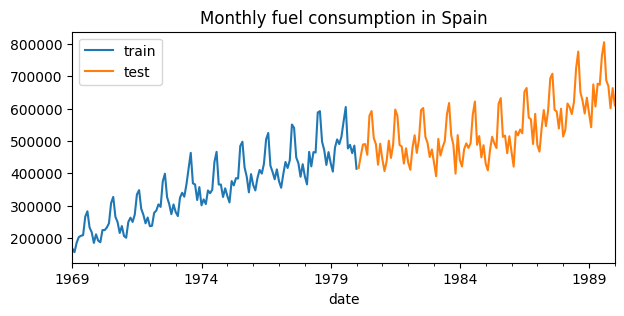

In [3]:
# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

Test stationarity for original series
-------------------------------------
ADF Statistic: -0.44612980998227797, p-value: 0.902107192394267
KPSS Statistic: 2.2096370946978383, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -3.6417276900323214, p-value: 0.005011605002137275
KPSS Statistic: 0.313271162357279, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -8.233942641655972, p-value: 5.959599575497111e-13
KPSS Statistic: 0.08065668267482215, p-value: 0.1


<Axes: title={'center': 'Differenced order 2'}, xlabel='date'>

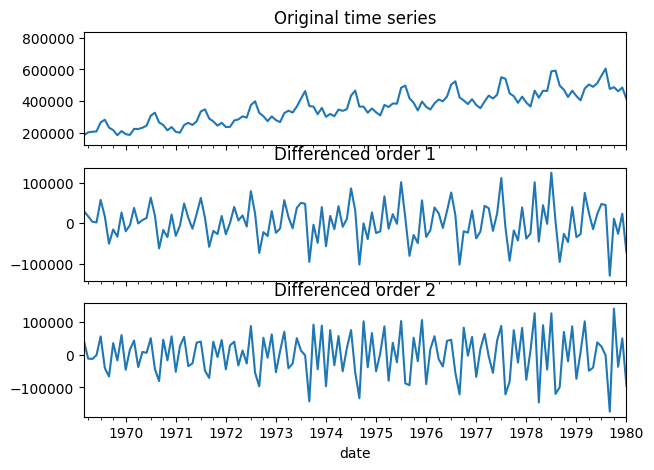

In [33]:
### Exploratory Analysis
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2')

Text(0.5, 1.0, 'Autocorrelation differentiated series (order=1)')

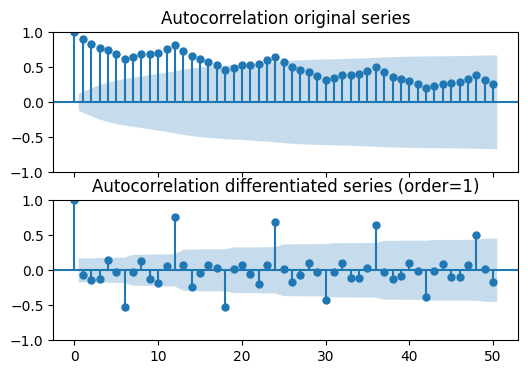

In [76]:
# Autocorrelation plot for original and differentiated series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)')

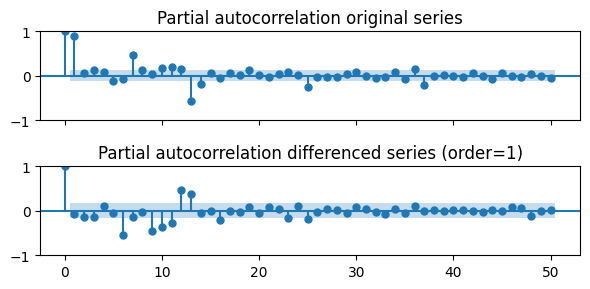

In [77]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)')
plt.tight_layout()

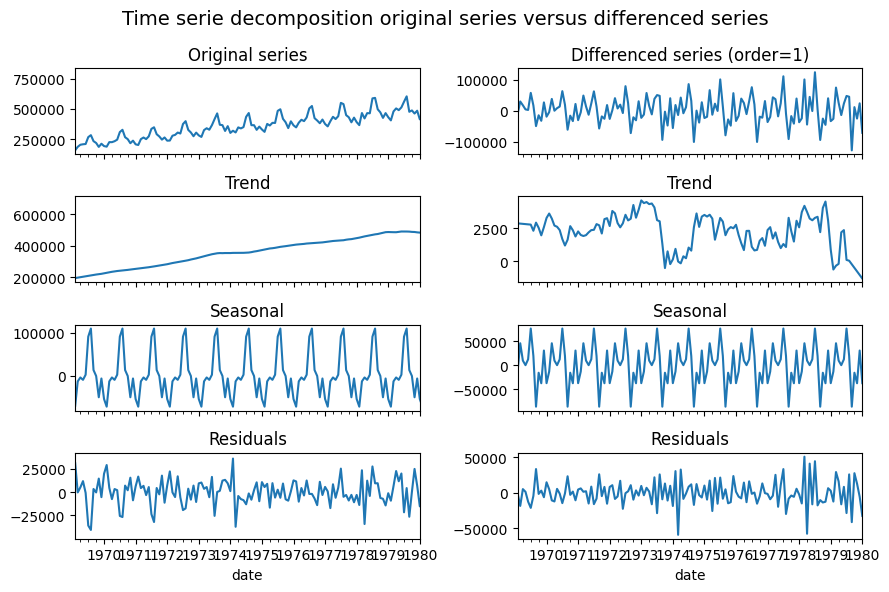

In [78]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])  
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout()

In [144]:
# First-order differentiation combined with seasonal differentiation
# ==============================================================================
data_diff_1_12 = data_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(data_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -4.387457230769955, p-value: 0.00031237732711269443
KPSS Statistic: 0.06291573421251052, p-value: 0.1


ARIMA models

In [164]:
# ARIMA with statsmodels.Sarimax (1,1,1)
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
# model_res.summary()

predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels(1,1,1)'
# display(predictions_statsmodels.head(4))

In [165]:
# ARIMA with statsmodels.Sarimax (1,1,4)
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
# model_res.summary()

predictions_statsmodels2 = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels2.name = 'predictions_statsmodels(1,1,4)'
# display(predictions_statsmodels.head(4))

In [146]:
# ARIMA with skforecast.Sarimax
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()
warnings.filterwarnings("default")

predictions_skforecast = model.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
# display(predictions_skforecast.head(4))

In [10]:
# ARIMA with pmdarima.Sarimax
model = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
# model.summary()

predictions_pmdarima = model.predict(len(data_test))
predictions_pmdarima.name = 'predictions_pmdarima'
# display(predictions_pmdarima.head(4))

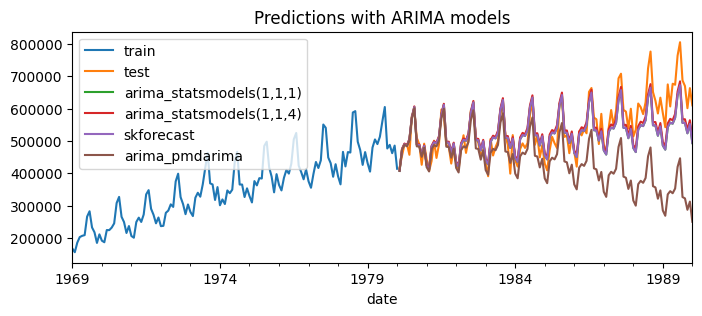

In [169]:
# Plot predictions
fig, ax = plt.subplots(figsize=(8, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_statsmodels.plot(ax=ax, label='arima_statsmodels(1,1,1)')
predictions_statsmodels2.plot(ax=ax, label='arima_statsmodels(1,1,4)')
predictions_skforecast.plot(ax=ax, label='arima_skforecast')
predictions_pmdarima.plot(ax=ax, label='arima_pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Exponential Smoothing

In [152]:
# Simple Exponential Smoothing (USAGE: when no trend and seasonality, real time and lack of data)
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SimpleExpSmoothing(data_train, initialization_method="estimated")
model_res = model.fit(smoothing_level=0.4)
warnings.filterwarnings("default")

predictions_ses = model_res.forecast(len(data_test))
# display(predictions_ses.head(4))

In [153]:
# Double exponential smoothing, Holt's method (USAGE: when trend, consistent upward or downward trend)
model = Holt(data_train, initialization_method="estimated")
model_res = model.fit()

predictions_holt = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [154]:
# Triple exponential smoothing, Holt-Winters method (USAGE: when trend and seasonality, with trends and repeating patterns)
model = ExponentialSmoothing(data_train, trend='add', seasonal='add')
model_res = model.fit()

predictions_holt_winters = model_res.forecast(len(data_test))

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


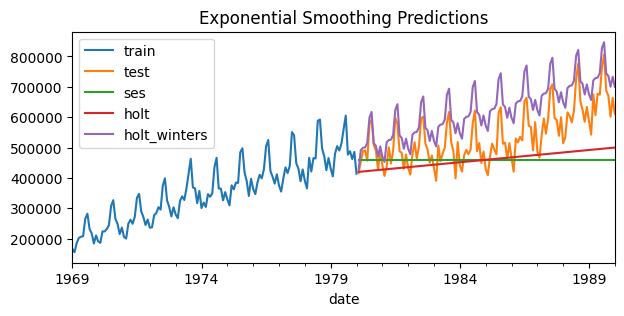

In [156]:
# Exponential Smoothing predictions
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_ses.plot(ax=ax, label='ses')
predictions_holt.plot(ax=ax, label='holt')
predictions_holt_winters.plot(ax=ax, label='holt_winters')
ax.set_title('Exponential Smoothing Predictions')
ax.legend()

In [ ]:
# Linear Regression / Multivariate Linear Regression
# Logistic Regression / Pattern Sequence Matching
# Requires an Exogonous variable

In [41]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = DynamicFactorMQ(endog=data_train)
model_res = model.fit()
warnings.filterwarnings("default")

predictions_dynamicFactorMQ = model_res.forecast(len(data_test))

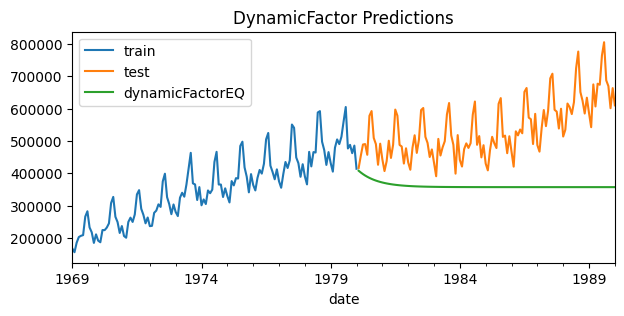

In [42]:
# DynamicFactor predictions
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_dynamicFactorMQ.plot(ax=ax, label='dynamicFactorEQ')
ax.set_title('DynamicFactor Predictions')
ax.legend()

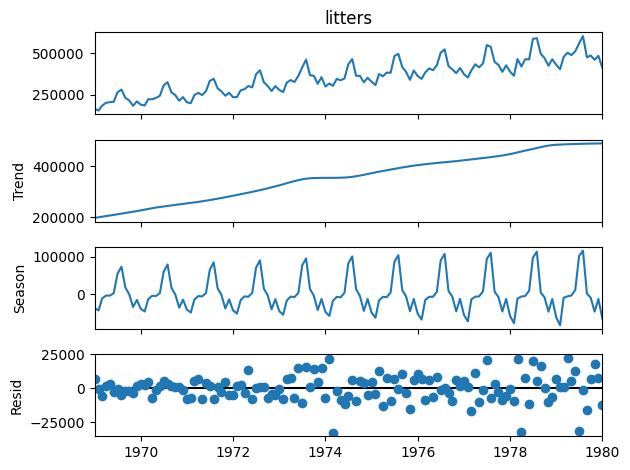

In [101]:
# Seasonal-Trend decomposition using LOESS (STL)
stl = STL(data_train, seasonal=13)
res = stl.fit()
res.plot()

stlf = STLForecast(data_train, SARIMAX, model_kwargs=dict(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)))
model_res = stlf.fit()
predictions_stlf = model_res.forecast(len(data_test))

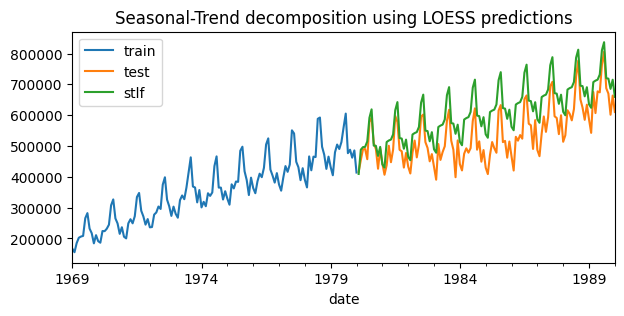

In [7]:
#  Seasonal-Trend decomposition using LOESS predictions
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_stlf.plot(ax=ax, label='stlf')
ax.set_title('Seasonal-Trend decomposition using LOESS predictions')
ax.legend()

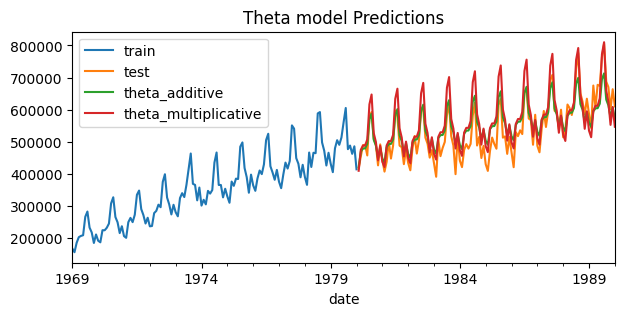

In [19]:
# Theta method
model = ThetaModel(data_train, period=12, method="additive")
model_res = model.fit()
predictions_theta = model_res.forecast(len(data_test))

model2 = ThetaModel(data_train, period=12, method="multiplicative")
model2_res = model2.fit()
predictions_theta2 = model2_res.forecast(len(data_test))

# Theta predictions
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_theta.plot(ax=ax, label='theta_additive')
predictions_theta2.plot(ax=ax, label='theta_multiplicative')

ax.set_title('Theta model Predictions')
ax.legend()

,ds,y
0,1969-01-01 00:00:00,166875.2129
1,1969-02-01 00:00:00,155466.8105
2,1969-03-01 00:00:00,184983.6699
3,1969-04-01 00:00:00,202319.8164
4,1969-05-01 00:00:00,206259.1523
5,1969-06-01 00:00:00,208411.8379
6,1969-07-01 00:00:00,265736.7207
7,1969-08-01 00:00:00,282287.0176
8,1969-09-01 00:00:00,232225.9316
9,1969-10-01 00:00:00,217133.9355


cmdstanpy  DEBUG cmd: where.exe tbb.dll
cwd: None


cmdstanpy  DEBUG TBB already found in load path
prophet    INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: C:\Users\sebas\AppData\Local\Temp\tmpzruegglk\afg1megm.json
cmdstanpy  DEBUG input tempfile: C:\Users\sebas\AppData\Local\Temp\tmpzruegglk\5042hhy5.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['C:\\Users\\sebas\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=15072', 'data', 'file=C:\\Users\\sebas\\AppData\\Local\\Temp\\tmpzruegglk\\afg1megm.json', 'init=C:\\Users\\sebas\\AppData\\Local\\Temp\\tmpzruegglk\\5042hhy5.json', 'output', 'file=C:\\Users\\sebas\\AppData\\Local\\Temp\\tmpzruegglk\\prophet_modelv3bmwerx\\prophet_model-20241105094623.csv', 'method=optimiz

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1969-01-01,192152.432078,133647.624352,169806.612711,192152.432078,192152.432078,-40592.860315,-40592.860315,-40592.860315,-40592.860315,-40592.860315,-40592.860315,0.0,0.0,0.0,151559.571764
1,1969-02-01,194860.024612,120020.659728,154186.397783,194860.024612,194860.024612,-56962.420797,-56962.420797,-56962.420797,-56962.420797,-56962.420797,-56962.420797,0.0,0.0,0.0,137897.603815
2,1969-03-01,197305.592062,165177.693933,200190.472759,197305.592062,197305.592062,-15166.550508,-15166.550508,-15166.550508,-15166.550508,-15166.550508,-15166.550508,0.0,0.0,0.0,182139.041554
3,1969-04-01,200013.184595,179471.722525,215312.616346,200013.184595,200013.184595,-2900.439808,-2900.439808,-2900.439808,-2900.439808,-2900.439808,-2900.439808,0.0,0.0,0.0,197112.744787
4,1969-05-01,202633.435434,180191.887628,216030.527936,202633.435434,202633.435434,-3974.863260,-3974.863260,-3974.863260,-3974.863260,-3974.863260,-3974.863260,0.0,0.0,0.0,198658.572174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1980-04-26,509599.117464,479050.715818,512989.375577,509553.296741,509639.348570,-14095.585689,-14095.585689,-14095.585689,-14095.585689,-14095.585689,-14095.585689,0.0,0.0,0.0,495503.531775
249,1980-04-27,509668.508778,479596.764809,516425.639752,509622.234065,509709.418147,-11980.488536,-11980.488536,-11980.488536,-11980.488536,-11980.488536,-11980.488536,0.0,0.0,0.0,497688.020242
250,1980-04-28,509737.900092,483407.987546,518394.595715,509691.179883,509779.487723,-9781.233372,-9781.233372,-9781.233372,-9781.233372,-9781.233372,-9781.233372,0.0,0.0,0.0,499956.666720
251,1980-04-29,509807.291406,485605.260820,519320.803391,509759.982844,509850.031415,-7581.990334,-7581.990334,-7581.990334,-7581.990334,-7581.990334,-7581.990334,0.0,0.0,0.0,502225.301072


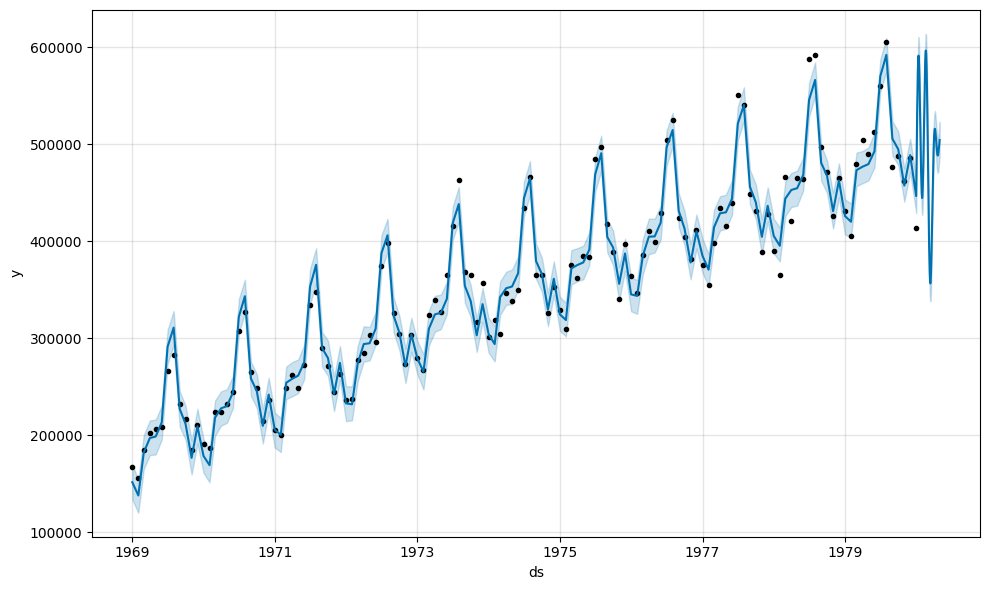

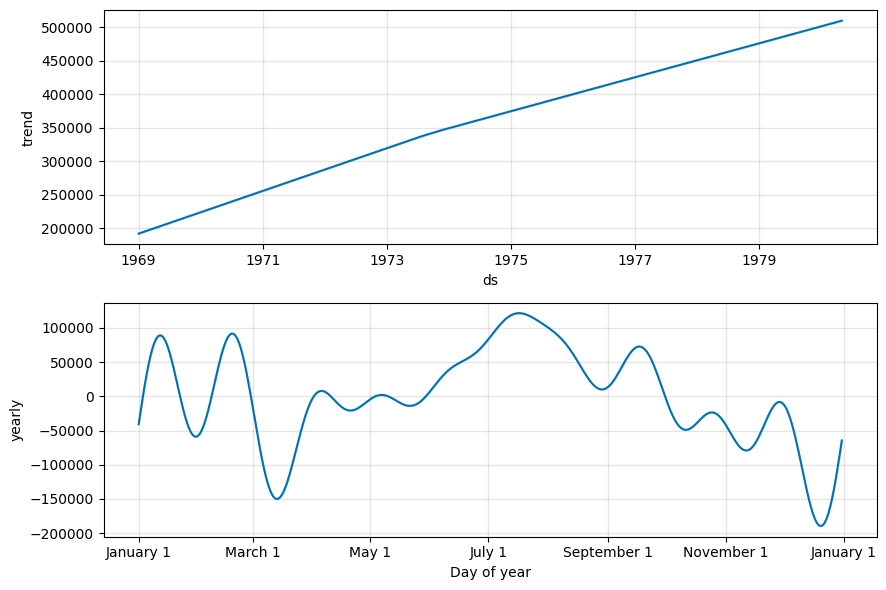

In [96]:
_data_train = pd.DataFrame((data_train.index, data_train.values)).T
_data_train.columns = ['ds', 'y']
display(_data_train.head(10))

model = Prophet()
model_res = model.fit(_data_train)
future = model.make_future_dataframe(periods=len(data_test))
forecast = model.predict(future)
display(forecast)

fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

In [28]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))
predictions.head(4)

1980-02-01    407504.056952
1980-03-01    473997.245816
1980-04-01    489983.091485
1980-05-01    485517.462872
Freq: MS, Name: pred, dtype: float64

In [29]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order          = (1, 1, 1),
                                seasonal_order =(1, 1, 1, 12),
                                maxiter        = 200
                             )
             )
metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data,
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )
display(metric)
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Valid

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


,mean_absolute_error
0,19611.236348


,pred
1980-02-01,407504.056952
1980-03-01,473997.245816
1980-04-01,489983.091485
1980-05-01,485517.462872


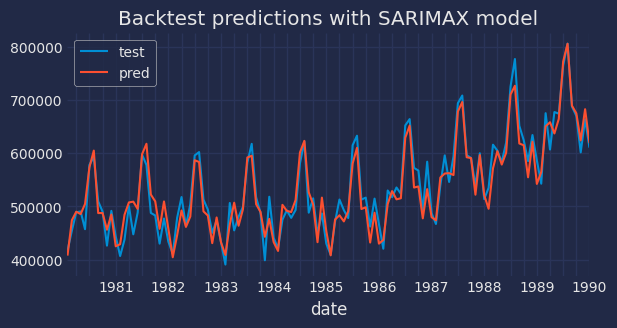

In [31]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend()

Train dates      : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Validation dates : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Test dates       : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


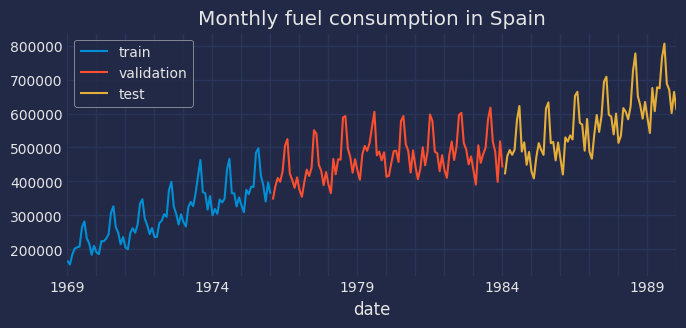

In [32]:
# Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val = '1984-01-01 23:59:59'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

In [33]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor = Sarimax(
                                order   = (1, 1, 1), # Placeholder replaced in the grid search
                                maxiter = 500
                             )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid.head(5)

Number of models compared: 45.


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
params grid: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897505,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897505,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376852,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376852,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.728960,"(2, 1, 1)","(1, 1, 1, 12)",n


In [34]:
# Auto arima: selection based on AIC
# ==============================================================================
model = auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=1.86 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=2.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.47 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.45 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=2.03 sec
 ARIMA(1,1,1)(1,1,0

In [41]:
# Capture auto_arima trace in a pandas dataframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,   # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC").reset_index(drop=True)

,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.47
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.43
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.40
3,"(1,1,1)","(0,1,2,12)",,3835.160,1.82
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.54
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.45
6,"(2,1,1)","(0,1,1,12)",,3836.104,1.13
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.67
8,"(1,1,1)","(1,1,2,12)",,3836.443,3.11
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.31


In [42]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Backtest predictions with the best model according to auto-arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), maxiter=500),
             )

metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py:580: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,19803.080728


Metric (mean_absolute_error) for auto arima-model:


,mean_absolute_error
0,20149.352199


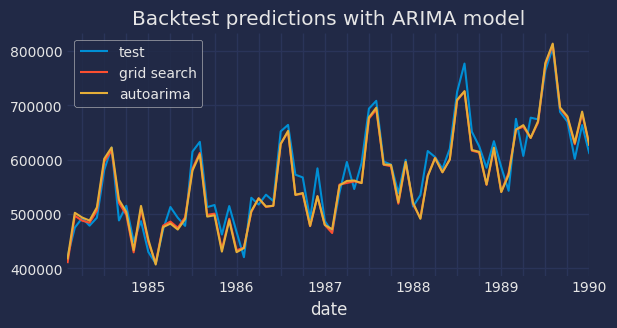

In [43]:
# Compare predictions
# ==============================================================================
print("Metric (mean_absolute_error) for grid search model:")
display(metric_m1)
print("Metric (mean_absolute_error) for auto arima-model:")
display(metric_m2)

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend()

Train dates       : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Last window dates : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


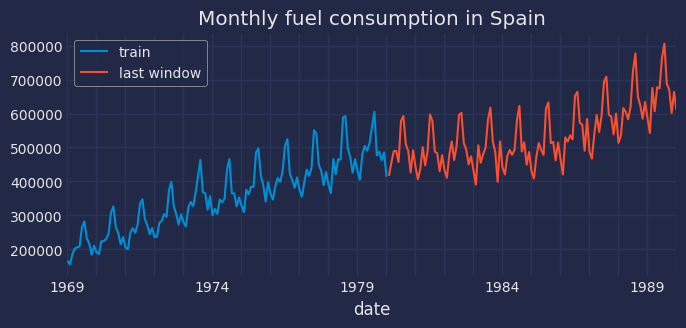

In [44]:
# Split data Train - Last window
# ==============================================================================
end_train = '1980-01-01 23:59:59'                       
print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='last window')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend()

In [45]:
# Train ARIMA forecaster with values from 1969-01-01 to 1980-01-01
# ==============================================================================
forecaster = ForecasterSarimax(
                regressor = Sarimax(
                    order          = (0, 1, 1),
                    seasonal_order = (1, 1, 1, 12),
                    maxiter        = 500
                )
)
forecaster.fit(y=data.loc[:end_train])

In [46]:
# Predict using last window
# ==============================================================================
predictions = forecaster.predict(
                  steps       = 12,
                  last_window = data.loc[end_train:]
              )
predictions.head(3)

1990-02-01    580893.320808
1990-03-01    693624.449209
1990-04-01    654315.472044
Freq: MS, Name: pred, dtype: float64